# RNetwork Visualization - Quadruped

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils
from envs import quadruped_utils as quadruped_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.utils import load
from exploration_buffer import ExplorationBuffer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config Utils

In [3]:
cfg_path = f"../conf/config.yaml"

env_name = 'quadruped'

cfg = OmegaConf.load(cfg_path)
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')
env_cfg.action_repeat=1
cfg = OmegaConf.merge(cfg, env_cfg)

cfg.rnet.model.remove_velocity=True

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cpu")

In [4]:
env = envs.make_env(cfg.env, space_info)
#expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

goals_file not found... garbage goals


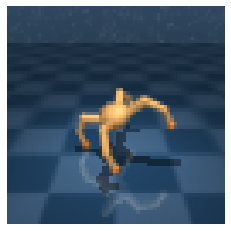

In [9]:
obs = env.reset()
plt.imshow(env.get_image_from_obs(obs).transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [12]:
from scipy.spatial.transform import Rotation

def get_quadruped_pose(global_rot, global_pos=0.5, legs={}, legs_rot=[0, 0, 0, 0]):
    """
    :param angles: along height, along depth, along left-right
    :param height:
    :param legs:
    :return:
    """
    if not isinstance(global_pos, list):
        global_pos = [0, 0, global_pos]
    pose = np.zeros([23])
    pose[0:3] = global_pos
    pose[3:7] = (Rotation.from_euler('XYZ', global_rot).as_quat())

    pose[[7, 11, 15, 19]] = legs_rot
    for k, v in legs.items():
        for leg in v:
            if k == 'out':
                pose[[8 + leg * 4]] = 0.5  # pitch
                pose[[9 + leg * 4]] = -1.0  # knee
                pose[[10 + leg * 4]] = 0.5  # ankle
            if k == 'inward':
                pose[[8 + leg * 4]] = -0.35  # pitch
                pose[[9 + leg * 4]] = 0.9  # knee
                pose[[10 + leg * 4]] = -0.5  # ankle
            elif k == 'down':
                pose[[8 + leg * 4]] = 1.0  # pitch
                pose[[9 + leg * 4]] = -0.75  # knee
                pose[[10 + leg * 4]] = -0.3  # ankle
            elif k == 'out_up':
                pose[[8 + leg * 4]] = -0.2  # pitch
                pose[[9 + leg * 4]] = -0.8  # knee
                pose[[10 + leg * 4]] = 1.  # ankle
            elif k == 'up':
                pose[[8 + leg * 4]] = -0.35  # pitch
                pose[[9 + leg * 4]] = -0.2  # knee
                pose[[10 + leg * 4]] = 0.6  # ankle

    return pose

def get_lexa_goals():
    # pose[0,1] is x,y
    # pose[2] is height
    # pose[3:7] are vertical rotations in the form of a quaternion (i think?)
    # pose[7:11] are yaw pitch knee ankle for the front left leg
    # pose[11:15] same for the front right leg
    # pose[15:19] same for the back right leg
    # pose[19:23] same for the back left leg

    
    lie_legs_together = get_quadruped_pose(
        [0, 3.14, 0], 0.2, dict(out_up=[0, 1, 2, 3]), [-0.7, 0.7, -0.7, 0.7]
    )
    lie_rotated = get_quadruped_pose([0.8, 3.14, 0], 0.2, dict(out_up=[0, 1, 2, 3]))
    lie_two_legs_up = get_quadruped_pose(
        [0.8, 3.14, 0], 0.2, dict(out_up=[1, 3], down=[0, 2])
    )

    lie_side = get_quadruped_pose(
        [0., 0, -1.57], 0.3, dict(out=[0,1,2, 3]), [-0.7, 0.7, -0.7, 0.7]
    )
    lie_side_back = get_quadruped_pose(
        [0., 0, 1.57], 0.3, dict(out=[0,1,2, 3]), [-0.7, 0.7, -0.7, 0.7]
    )
    stand = get_quadruped_pose([1.57, 0, 0], 0.2, dict(up=[0, 1, 2, 3]))
    stand_rotated = get_quadruped_pose([0.8, 0, 0], 0.2, dict(up=[0, 1, 2, 3]))
 
    stand_leg_up = get_quadruped_pose(
        [1.57, 0, 0.0], 0.7, dict(down=[0, 2, 3], out_up=[1])
    )
    attack = get_quadruped_pose([1.57, 0., -0.4], 0.7, dict(out=[0, 1, 2, 3]))
    balance_front = get_quadruped_pose([1.57, 0.0, 1.57], 0.7, dict(up=[0, 1, 2, 3]))
    balance_back = get_quadruped_pose([1.57, 0.0, -1.57], 0.7, dict(up=[0, 1, 2, 3]))
    balance_diag = get_quadruped_pose(
        [1.57, 0, 0.0], 0.7, dict(down=[0, 2], out_up=[1,3])
    )

    return np.stack([
        lie_legs_together,
        lie_rotated,
        lie_two_legs_up,
        lie_side,
        lie_side_back,
        stand,
        stand_rotated,
        stand_leg_up,
        attack,
        balance_front,
        balance_back,
        balance_diag
    ])

lexa_goals = get_lexa_goals()

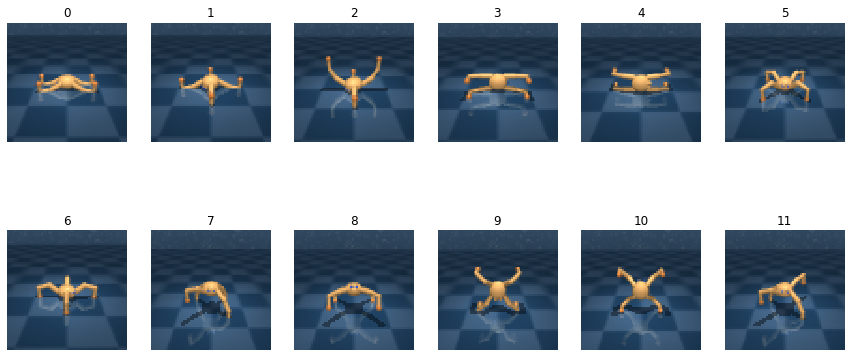

In [44]:
N = len(lexa_goals)

fig, ax = plt.subplots(2, N//2, figsize=(15, 7))
for i in range(N):
    state = quadruped_utils.get_state_from_lexa(env, lexa_goals[i])
    img = env.get_image_from_obs(state)
    ax[i//6, i%6].imshow(img.transpose((1, 2, 0)))
    ax[i//6, i%6].set_title(i)
    ax[i//6, i%6].axis('off')
plt.show()



In [ ]:
N = len(lexa_goals)
goals = {
    'state': lexa_goals,
    'vec_obs': np.zeros((N, cfg.env.obs.vec_size), dtype='float64'),
    'rgb_obs': np.zeros((N, 3, 64, 64), dtype='uint8')
}

for i in range(N):
    goals['vec_obs'][i] = quadruped_utils.get_state_from_lexa(env, lexa_goals[i])

## Load

In [9]:
cfg.rnet.model.hidden_size = 128
cfg.rnet.model.comp_n_layers = 4
cfg.rnet.model.feat_size = 128

model = RNetModel(cfg.rnet.model, space_info)
model.to(device)
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [10]:
cfg.rnet.memory.capacity = 2000
memory = RNetMemory(cfg.rnet.memory, space_info, cfg.rnet.model.feat_size, device)

In [14]:
exp_name = '20220509-173335_walker_memonly_thresh2_neg0_skip0.05'
save_dir = os.path.join('/checkpoint/sainbar/offline-gcrl/logs/', exp_name)

memory, NN, model = load(save_dir, memory, model)

Loading rnet objects from  /checkpoint/sainbar/offline-gcrl/logs/20220509-173335_walker_memonly_thresh2_neg0_skip0.05


## Visualize

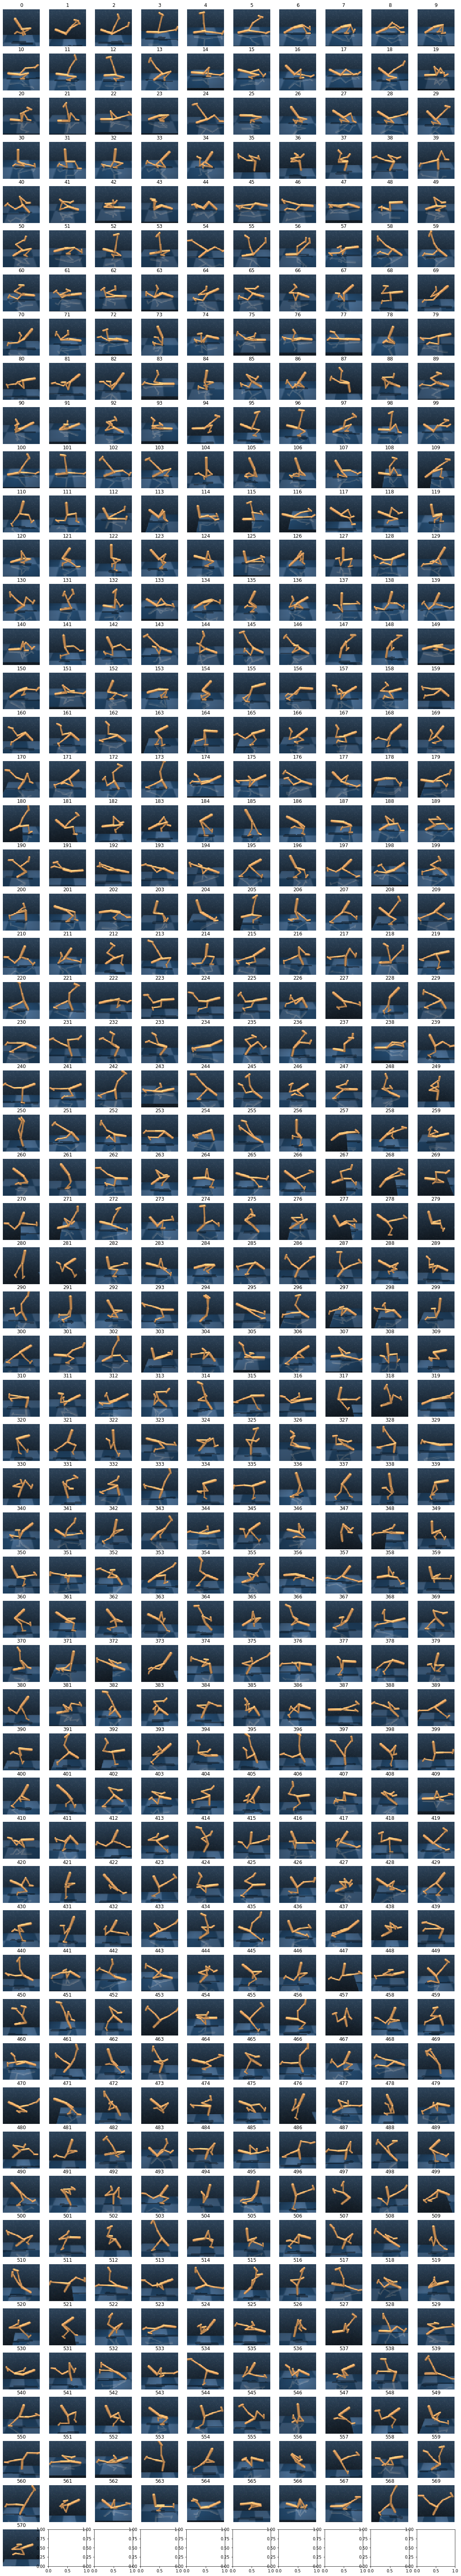

In [15]:
n = len(memory)
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

for i in range(n):
    state = memory.states[i]
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

In [25]:
def retrieve_path(pred, i, j):
    if pred[i, j] == -9999:
        return [i]
    path = retrieve_path(pred, i, pred[i, j])
    path.append(j)
    return path

def show_path(env, memory, i, j, state1, state2):
    path = retrieve_path(memory.pred, i, j)
    n = len(path)
    num_cols = n + 2
    num_rows = 1
    _, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))
    
    obs = walker_utils.get_state_from_lexa(env, state1[:9]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    
    for p in range(1, n+1):
        state = memory.states[path[p - 1]]
        obs = walker_utils.get_state_from_lexa(env, state[:9]) 
        img = env.get_image_from_obs(obs)
        ax[p].imshow(img.transpose((1, 2, 0)))
        ax[p].axis('off')
        ax[p].set_title(str(path[p - 1]))

    obs = walker_utils.get_state_from_lexa(env, state2[:9]) 
    img = env.get_image_from_obs(obs)
    ax[-1].imshow(img.transpose((1, 2, 0)))
    ax[-1].axis('off')

    plt.show()

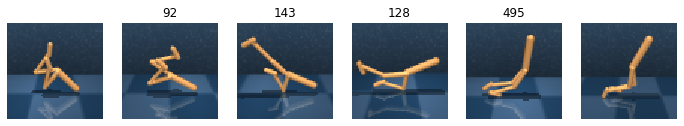

In [46]:
_, i1, j1 = expl_buffer.get_random_obs()
_, i2, j2 = expl_buffer.get_random_obs()
show_path(
    env,
    memory,
    NN["outgoing"][i1, j1],
    NN["incoming"][i2, j2],
    expl_buffer.states[i1, j1],
    expl_buffer.states[i2, j2]
)

tensor(73)
tensor(142)
tensor(164)
tensor(167)
tensor(147)


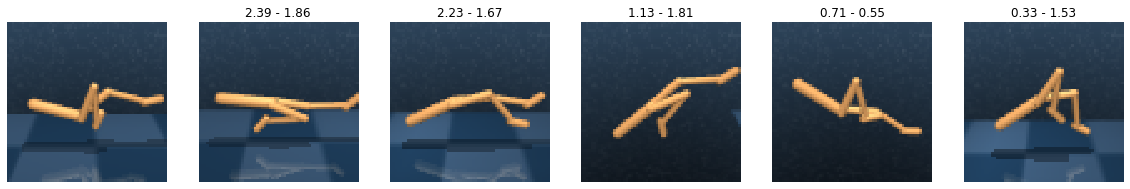

In [69]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx[i]]
        print(idx[i])
        obs = walker_utils.get_state_from_lexa(env, state_NN[:9]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out[idx[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()

obs, i, j = expl_buffer.get_random_obs()

i, j = 8291, 414
#i, j = 7080, 198
obs = expl_buffer.get_obs(i, j)
state = expl_buffer.states[i, j]
#state = env.goals['state'][i]
#obs = env.goals['vec_obs'][i]
show_kNN(env, model, memory, obs, state, k=5)

tensor(137)
tensor(196)
tensor(93)
tensor(309)
tensor(197)


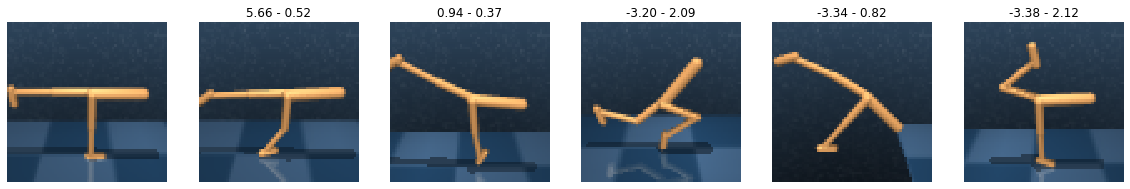

In [61]:
def get_NN(env, model, memory, obs, state):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    return idx[0].item()

i = np.random.randint(12)
#i=10
state = env.goals['state'][i]
obs = env.goals['vec_obs'][i]
#get_NN(env, model, memory, obs, state)
show_kNN(env, model, memory, obs, state, k=5)

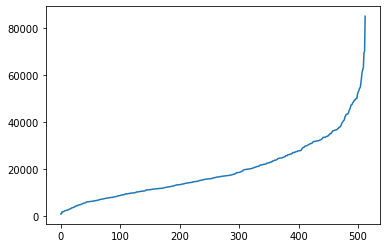

In [575]:
NN_flat = NN.flatten()
NN_flat.shape

NN_count = np.bincount(NN_flat)
NN_ind = np.argsort(NN_count)

#NN_sort = NN_flat[NN_ind]

#plt.hist(NN_flat, bins=len(memory))
#plt.show()

NN_sort = NN_count[NN_ind]

plt.plot(NN_sort)

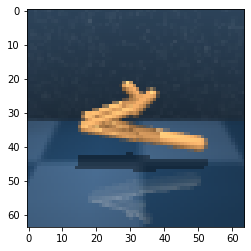

In [488]:
obs, i, j = expl_buffer.get_random_obs()
while not NN[i, j] == 69:
    obs, i, j = expl_buffer.get_random_obs()
obs = walker_utils.get_state_from_lexa(env, expl_buffer.states[i, j, :9]) 
img = env.get_image_from_obs(obs)
plt.imshow(img.transpose((1, 2, 0)))
plt.show()